In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('complaints.csv')

# Display basic info
print("Shape of dataset:", df.shape)
print(df.head())

# Focus on relevant columns
df = df[['Consumer complaint narrative', 'Product']]

# Drop null complaint narratives
df.dropna(subset=['Consumer complaint narrative'], inplace=True)

# Check top products
print("Unique Product Categories:\n", df['Product'].value_counts())


Shape of dataset: (11052506, 18)
  Date received                                            Product  \
0    2020-07-06  Credit reporting, credit repair services, or o...   
1    2025-09-18  Credit reporting or other personal consumer re...   
2    2025-09-04  Credit reporting or other personal consumer re...   
3    2025-09-18  Credit reporting or other personal consumer re...   
4    2025-09-05  Credit reporting or other personal consumer re...   

        Sub-product                                 Issue  \
0  Credit reporting  Incorrect information on your report   
1  Credit reporting  Incorrect information on your report   
2  Credit reporting  Incorrect information on your report   
3  Credit reporting  Incorrect information on your report   
4  Credit reporting           Improper use of your report   

                                       Sub-issue Consumer complaint narrative  \
0            Information belongs to someone else                          NaN   
1            Info

In [3]:
# Focus on relevant columns
df = df[['Consumer complaint narrative', 'Product']]

# Drop null complaint narratives
df.dropna(subset=['Consumer complaint narrative'], inplace=True)

# Check top products
print("Unique Product Categories:\n", df['Product'].value_counts())

Unique Product Categories:
 Product
Credit reporting or other personal consumer reports                             1342184
Credit reporting, credit repair services, or other personal consumer reports     807277
Debt collection                                                                  361923
Checking or savings account                                                      150487
Mortgage                                                                         133663
Credit card or prepaid card                                                      108666
Money transfer, virtual currency, or money service                               102367
Credit card                                                                       90489
Student loan                                                                      55881
Vehicle loan or lease                                                             42503
Credit reporting                                                                  31

In [4]:
print(df["Product"].isnull().sum()) #checking null values

0


In [5]:
print(df["Consumer complaint narrative"].isnull().sum()) #checking null values

0


In [6]:
# Define mapping for the mentioned classes in the task
category_map = {
    'Credit reporting, credit repair services, or other personal consumer reports': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Mortgage': 3
}

# Filter dataset
df = df[df['Product'].isin(category_map.keys())]

# Map to numeric labels
df['label'] = df['Product'].map(category_map)

print(df['label'].value_counts())


label
0    807277
1    361923
3    133663
2      9461
Name: count, dtype: int64


In [7]:
#NLP task 
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation & numbers
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
df['clean_text'] = df['Consumer complaint narrative'].apply(preprocess_text)

print(df[['Consumer complaint narrative', 'clean_text']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yuvasri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yuvasri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                         Consumer complaint narrative  \
20  I am listing accounts below that have been rep...   
37  In accordance with the Fair Credit Reporting a...   
44  On XX/XX/XXXX I requested the removal of Priva...   
47                         These are not my accounts.   
73  Ok this is for TransUnion. I originally challe...   

                                           clean_text  
20  listing account reported inaccurately credit r...  
37  accordance fair credit reporting act list acco...  
44  xxxxxxxx requested removal private mortgage in...  
47                                            account  
73  ok transunion originally challenged issue xxxx...  


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Split data into train & test
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vectorization
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [11]:
from sklearn.linear_model import LogisticRegression#multiclassification models
from sklearn.naive_bayes import MultinomialNB


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB()
   
}

results = {}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    acc = model.score(X_test_tfidf, y_test)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")


Logistic Regression Accuracy: 0.9134
Naive Bayes Accuracy: 0.8638



Classification Report:

                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.93      0.95      0.94    161455
                                                             Debt collection       0.88      0.84      0.86     72385
                                                               Consumer Loan       0.70      0.39      0.50      1892
                                                                    Mortgage       0.93      0.93      0.93     26733

                                                                    accuracy                           0.91    262465
                                                                   macro avg       0.86      0.78      0.81    262465
                                                                weighted avg       0.91      0.91      0.91    262465



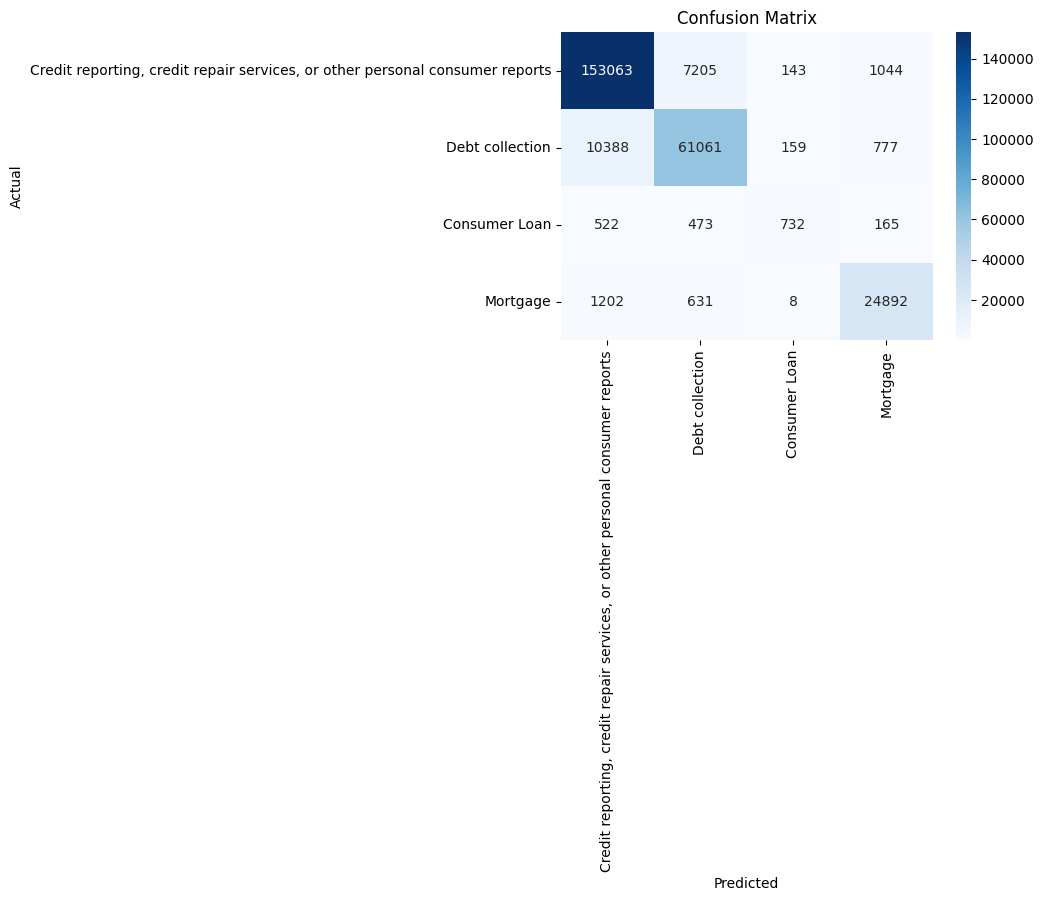

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
#chose the model with best accuracy for model evaluation

best_model = models['Logistic Regression']

y_pred = best_model.predict(X_test_tfidf)

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=category_map.keys()))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=category_map.keys(),
            yticklabels=category_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [13]:
def predict_category(text):
    cleaned = preprocess_text(text)
    vectorized = tfidf.transform([cleaned])
    pred_label = best_model.predict(vectorized)[0]
    
    inv_map = {v: k for k, v in category_map.items()}
    return inv_map[pred_label]

# predicting the classification for a given sample complaint
new_complaint = "My mortgage company is harassing me with late fees"
print("Predicted Category:", predict_category(new_complaint))


Predicted Category: Mortgage
